In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [3]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


In [4]:
def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

In [5]:
def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, num_neighbours):
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    
    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)

  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  #print(next_barycenter.shape)  
  return A, next_barycenter, remaining_indices


In [6]:
def get_convergent_barycenters(point_cloud, no_neighbours, initial_pt):    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) < 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary



        neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, no_neighbours)



        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


        #print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance == 0.0):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            rem_indices = rem_set
            #print("Sampled barycenters are")
            #print(sampled_barycenters)
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters

# Sphere of spheres

In [7]:
x, y, z = sp.symbols('x y z')
expr = x**2 + y**2 + z**2 - 0.5
poly = sp.Poly(expr, x, y, z)

# convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)

#sample points
small_spheres = sample_points_on_poly(50,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [8]:
expr_bigsp = x**2 + y**2 + z**2 - 16
poly_bigsp = sp.Poly(expr_bigsp, x, y, z)

# convert sympy polynomial to minyterpy polynomial
newt_poly_bigsp = sympy_to_mp(poly_bigsp, mp.NewtonPolynomial)


#sample points
big_sphere = sample_points_on_poly(80,        # Number of points to be sampled
                                   newt_poly_bigsp,  # Polynomial in Newton basis
                                   bounds=16, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [9]:
small_spheres.shape

(50, 3)

In [10]:
big_sphere.shape

(80, 3)

In [11]:
sphere_of_spheres = small_spheres

for i in range(big_sphere.shape[0]):
    next_sphere = small_spheres + big_sphere[i]
    
    sphere_of_spheres = np.concatenate((sphere_of_spheres, next_sphere), axis=0)


In [12]:
sphere_of_spheres.shape

(4050, 3)

In [13]:

x_n = sphere_of_spheres[:,0]

y_n = sphere_of_spheres[:,1]

z_n = sphere_of_spheres[:,2]


plot_points = [x_n,y_n,z_n]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [14]:
# get the barycenters for given point cloud

spherical_spheres_bary = get_convergent_barycenters(sphere_of_spheres, 20, sphere_of_spheres[0])

#20 is the number of neighbours samples wach time

In [15]:
spherical_spheres_bary.shape

torch.Size([450, 3])

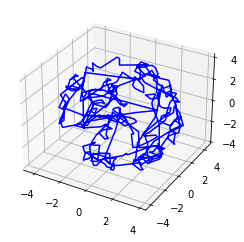

In [16]:
#Trajectory of sampled barycenters of sphere of spheres

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = spherical_spheres_bary[:,0]
Y = spherical_spheres_bary[:,1]
Z = spherical_spheres_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show() 

/tmp/ipykernel_62899/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


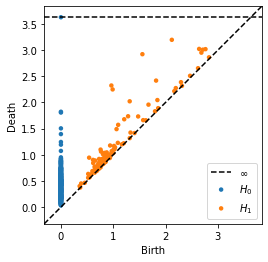

In [17]:
_, PH_diagram_sphere_of_spheres_bary = get_persistence_diagram(spherical_spheres_bary,1)

# Circle of spheres

In [18]:
num_pts = 8
radius = 4.
angles = np.linspace(0.,360.,num_pts)
angles_in_rad = (angles*22)/(7*180)

x_arr = radius* np.cos(angles_in_rad)
y_arr = radius* np.sin(angles_in_rad)
z_arr = np.zeros(num_pts)

points = np.dstack((x_arr, y_arr, z_arr))
circle_points_3d = points.reshape(num_pts,3)

In [19]:
#circular_spheres = point_data
circular_spheres = np.array([[4.0,0.0,0]])

for i in range(circle_points_3d.shape[0]):
    next_sphere = small_spheres + circle_points_3d[i]
    
    circular_spheres = np.concatenate((circular_spheres, next_sphere), axis=0)
#print(fancy_sphere.shape)
    
#fancy_sphere = np.reshape(int(fancy_sphere.shape[0]/3), 3)

In [20]:
circular_spheres.shape

(401, 3)

In [21]:

x_cs = circular_spheres[:,0]

y_cs = circular_spheres[:,1]

z_cs = circular_spheres[:,2]


plot_points = [x_cs,y_cs,z_cs]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [22]:
# get the barycenters for given point cloud

circular_spheres_bary = get_convergent_barycenters(circular_spheres, 20, circular_spheres[0])

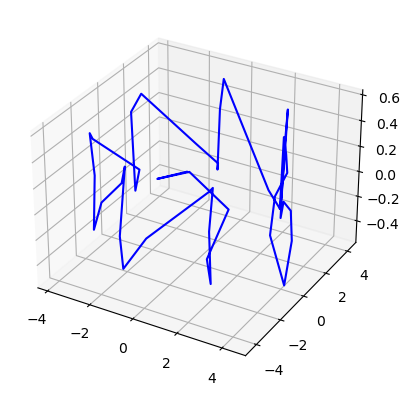

In [23]:
#Trajectory of sampled barycenters

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = circular_spheres_bary[:,0]
Y = circular_spheres_bary[:,1]
Z = circular_spheres_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

In [24]:
circular_spheres_bary.shape

torch.Size([44, 3])

In [25]:
#plotting barycenetrs
x_csb = circular_spheres_bary[:,0]

y_csb = circular_spheres_bary[:,1]

z_csb = circular_spheres_bary[:,2]


plot_points = [x_csb,y_csb,z_csb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

/tmp/ipykernel_62899/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


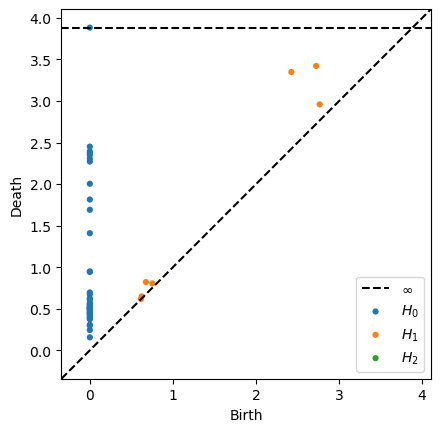

In [26]:
_,PH_diagram_circular_spheres_bary = get_persistence_diagram(circular_spheres_bary,2)

# Perpendicular circles of spheres

In [27]:
# to get circle 1

num_pts_p = 8
radius_p = 4.
angles_p = np.linspace(0.,360.,num_pts_p)
angles_in_rad = (angles_p*22)/(7*180)

x_arr = radius_p* np.cos(angles_in_rad)
y_arr = radius_p* np.sin(angles_in_rad)
z_arr = np.zeros(num_pts)

points = np.dstack((x_arr, y_arr, z_arr))
circle_points_3d = points.reshape(num_pts,3)


#circular_spheres = point_data
circular_spheres = np.array([[4.0,0.0,0]])

for i in range(circle_points_3d.shape[0]):
    next_sphere = small_spheres + circle_points_3d[i]
    
    circular_spheres = np.concatenate((circular_spheres, next_sphere), axis=0)
#print(fancy_sphere.shape)
    
#fancy_sphere = np.reshape(int(fancy_sphere.shape[0]/3), 3)

In [28]:
# to get perpendicular circle 2

points2 = np.dstack((x_arr, z_arr, y_arr))
circle_points_3d_2 = points2.reshape(num_pts,3)



#circular_spheres = point_data
circular_spheres2 = np.array([[4.0,0.0,0]])

for i in range(circle_points_3d.shape[0]):
    next_sphere = small_spheres + circle_points_3d_2[i]
    
    circular_spheres2 = np.concatenate((circular_spheres2, next_sphere), axis=0)

In [29]:
circular_spheres_f = np.concatenate((circular_spheres, circular_spheres2), axis=0)

In [30]:
circular_spheres_f.shape

(802, 3)

In [31]:

x_cs = circular_spheres_f[:,0]

y_cs = circular_spheres_f[:,1]

z_cs = circular_spheres_f[:,2]


plot_points = [x_cs,y_cs,z_cs]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [32]:

# get the barycenters for given point cloud

circular_spheres_f_bary = get_convergent_barycenters(circular_spheres_f, 20, circular_spheres_f[0])

#20 is the number of neighbours samples wach time

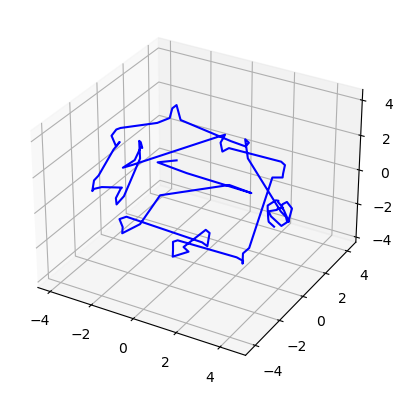

In [33]:
#Trajectory of sampled barycenters

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = circular_spheres_f_bary[:,0]
Y = circular_spheres_f_bary[:,1]
Z = circular_spheres_f_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

In [34]:
circular_spheres_f_bary.shape

torch.Size([94, 3])

In [35]:
#plotting barycenetrs
x_csb = circular_spheres_f_bary[:,0]

y_csb = circular_spheres_f_bary[:,1]

z_csb = circular_spheres_f_bary[:,2]


plot_points = [x_csb,y_csb,z_csb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

/tmp/ipykernel_62899/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


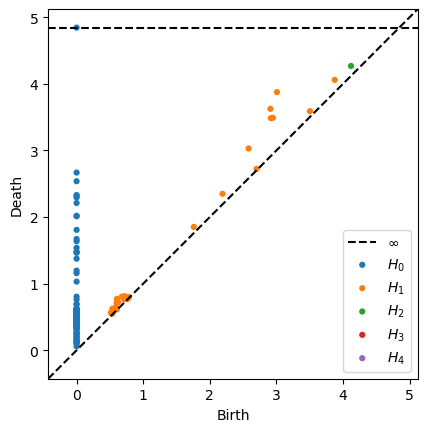

In [36]:
dg, PH_diagram_circular_spheres_bary = get_persistence_diagram(circular_spheres_f_bary,4)

In [37]:
dg

[array([[0.        , 0.0601134 ],
        [0.        , 0.09827288],
        [0.        , 0.10934693],
        [0.        , 0.12788278],
        [0.        , 0.1305092 ],
        [0.        , 0.13848907],
        [0.        , 0.15080065],
        [0.        , 0.17333187],
        [0.        , 0.20031935],
        [0.        , 0.20522964],
        [0.        , 0.22631674],
        [0.        , 0.24706785],
        [0.        , 0.25969788],
        [0.        , 0.26036239],
        [0.        , 0.28669339],
        [0.        , 0.31631428],
        [0.        , 0.33103687],
        [0.        , 0.33409694],
        [0.        , 0.3397488 ],
        [0.        , 0.34566155],
        [0.        , 0.35102087],
        [0.        , 0.35389212],
        [0.        , 0.35704425],
        [0.        , 0.36284301],
        [0.        , 0.36966434],
        [0.        , 0.40159535],
        [0.        , 0.40742636],
        [0.        , 0.40869069],
        [0.        , 0.41082254],
        [0.   

# Testing PH higher dim

In [38]:
#circle of traingles


In [39]:
num_pts = 8
radius = 4.
angles = np.linspace(0.,360.,num_pts)
angles_in_rad = (angles*22)/(7*180)

x_arr = radius* np.cos(angles_in_rad)
y_arr = radius* np.sin(angles_in_rad)
z_arr = np.zeros(num_pts)

points = np.dstack((x_arr, y_arr, z_arr))
circle_points_3d = points.reshape(num_pts,3)

In [40]:
circle_points_3d

array([[ 4.        ,  0.        ,  0.        ],
       [ 2.4928292 ,  3.12822675,  0.        ],
       [-0.8929013 ,  3.89906749,  0.        ],
       [-3.60575441,  1.73162788,  0.        ],
       [-3.60136363, -1.74074121,  0.        ],
       [-0.8830378 , -3.90131314,  0.        ],
       [ 2.50073243, -3.12191244,  0.        ],
       [ 3.99998721,  0.0101159 ,  0.        ]])

In [41]:

x_n = circle_points_3d[:,0]

y_n = circle_points_3d[:,1]

z_n = circle_points_3d[:,2]


plot_points = [x_n,y_n,z_n]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [42]:
#  irregular traingle in 3d

#triangle = np.array([[0.0, 0.0, 0.0],[1.0, 0.0, 0.0],[2.0, 2.0, 0.0]])

#trl2 : using the below, a hole of triangles seems to form and dies soon
#triangle = np.array([[0.0, 0.0, 0.0],[1.0, 0.0, 0.0]])

#trial 3
triangle = np.array([[0.0, 0.0, 0.0],[1.0, 0.0, 0.0],[1.1, 0.0, 1.0], [0.0, 1.0, 0.0]])


In [43]:
# make a circle of these triangles

In [44]:
#circular_triangles = point_data
circular_triangles = triangle + circle_points_3d[0]

for i in range(circle_points_3d.shape[0]-1):
    next_sphere = triangle*0.1*i + circle_points_3d[i+1]
    
    circular_triangles = np.concatenate((circular_triangles, next_sphere), axis=0)
#print(fancy_sphere.shape)
    
#fancy_sphere = np.reshape(int(fancy_sphere.shape[0]/3), 3)

In [45]:
circular_triangles.shape

(32, 3)

In [46]:

x_a = circular_triangles[:,0]

y_b = circular_triangles[:,1]

z_c = circular_triangles[:,2]


plot_points = [x_a,y_b,z_c]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

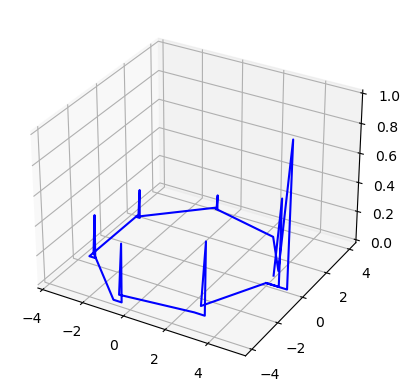

In [47]:
#Trajectory of sampled barycenters of sphere of spheres

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = circular_triangles[:,0]
Y = circular_triangles[:,1]
Z = circular_triangles[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show() 

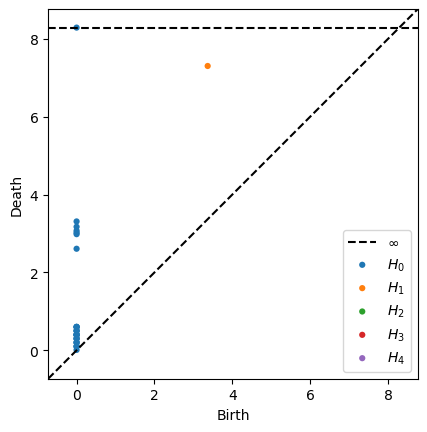

In [48]:
test, PH_diagram_test_bary = get_persistence_diagram(circular_triangles,4)

In [49]:
test

[array([[0.        , 0.01011591],
        [0.        , 0.1       ],
        [0.        , 0.1       ],
        [0.        , 0.10049876],
        [0.        , 0.2       ],
        [0.        , 0.2       ],
        [0.        , 0.20099752],
        [0.        , 0.30000001],
        [0.        , 0.30000001],
        [0.        , 0.30149627],
        [0.        , 0.38988408],
        [0.        , 0.40000001],
        [0.        , 0.40000001],
        [0.        , 0.40014067],
        [0.        , 0.40199503],
        [0.        , 0.5       ],
        [0.        , 0.5       ],
        [0.        , 0.5024938 ],
        [0.        , 0.59473825],
        [0.        , 0.60000002],
        [0.        , 0.60000002],
        [0.        , 0.60299253],
        [0.        , 2.60785604],
        [0.        , 2.98223305],
        [0.        , 3.02030253],
        [0.        , 3.0713594 ],
        [0.        , 3.1723721 ],
        [0.        , 3.30939746],
        [0.        ,        inf]]),
 array([[3.3

note about the above obswrvation: 

In [50]:
plot_points

[array([ 4.        ,  5.        ,  5.1       ,  4.        ,  2.4928292 ,
         2.4928292 ,  2.4928292 ,  2.4928292 , -0.8929013 , -0.7929013 ,
        -0.7829013 , -0.8929013 , -3.60575441, -3.40575441, -3.38575441,
        -3.60575441, -3.60136363, -3.30136363, -3.27136363, -3.60136363,
        -0.8830378 , -0.4830378 , -0.4430378 , -0.8830378 ,  2.50073243,
         3.00073243,  3.05073243,  2.50073243,  3.99998721,  4.59998721,
         4.65998721,  3.99998721]),
 array([ 0.        ,  0.        ,  0.        ,  1.        ,  3.12822675,
         3.12822675,  3.12822675,  3.12822675,  3.89906749,  3.89906749,
         3.89906749,  3.99906749,  1.73162788,  1.73162788,  1.73162788,
         1.93162788, -1.74074121, -1.74074121, -1.74074121, -1.44074121,
        -3.90131314, -3.90131314, -3.90131314, -3.50131314, -3.12191244,
        -3.12191244, -3.12191244, -2.62191244,  0.0101159 ,  0.0101159 ,
         0.0101159 ,  0.6101159 ]),
 array([0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ,